In [1]:
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Comments for documentation:
# - `import tensorflow as tf`: Import TensorFlow for building and training machine learning models.
# - `import os`: Import os module to interact with the operating system, e.g., reading file paths.
# - `import pandas as pd`: Import pandas for data manipulation and analysis.
# - `import numpy as np`: Import NumPy for numerical operations on arrays and matrices.
# - `import matplotlib as plt`: Import matplotlib for creating static, interactive, and animated visualizations in Python.
# - `from sklearn.metrics import mean_squared_error as mse`: Import mean_squared_error from sklearn for calculating the MSE metric for model evaluation.
# - `from sklearn.preprocessing import MinMaxScaler`: Import MinMaxScaler from sklearn for feature scaling by normalizing or standardizing features.
# - `import warnings`: Import warnings module to suppress warnings.
# - `import matplotlib.pyplot as plt`: Import pyplot from matplotlib for plotting graphs.
# - `warnings.filterwarnings('ignore')`: Set up warnings to ignore them to avoid clutter in the output.
# - `%matplotlib inline`: Enable inline plotting for Jupyter notebooks, making plots appear in the notebook itself.


In [3]:
df = pd.read_csv('Timeseries_14_P.csv', skiprows=10)
season = {'Winter':1,'Spring':2,'Summer':3,'Autumn':4}
df = df[:157776:]
df.index = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
df.tail()

,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
time,,,,,,,,,
2022-12-31 19:07:00,20221231:1907,0.0,0.0,0.0,0.0,0.0,17.97,1.93,0.0
2022-12-31 20:07:00,20221231:2007,0.0,0.0,0.0,0.0,0.0,16.78,2.00,0.0
2022-12-31 21:07:00,20221231:2107,0.0,0.0,0.0,0.0,0.0,16.28,2.07,0.0
2022-12-31 22:07:00,20221231:2207,0.0,0.0,0.0,0.0,0.0,15.60,2.07,0.0
2022-12-31 23:07:00,20221231:2307,0.0,0.0,0.0,0.0,0.0,15.21,1.86,0.0


In [4]:
df['Gb(i)'] = pd.to_numeric(df['Gb(i)'], errors='coerce')
df['P'] = pd.to_numeric(df['P'], errors='coerce')

day  = 60 * 60 * 24
year =  365.2425 * day
month = 30 * day

df["Seconds"] = df.index.map(pd.Timestamp.timestamp)
df ["day sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /day))
df ["day cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /day))
# df ["year sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /year))
# df ["year cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /year))

# 1971
df = df.drop(["Seconds"], axis = 1)

# Check for any NaN values after conversion
# print("NaN values in G(i):", df['G(i)'].isna().sum())
df= df[df['Gb(i)'] > 10]

def get_season(month):
    if month in [12, 1, 2]:
        return season['Winter']
    elif month in [3, 4, 5]:
        return season['Spring']
    elif month in [6, 7, 8]:
        return season['Summer']
    elif month in [9, 10, 11]:
        return season['Autumn']

# Apply the function to create the season column
df['Season'] = df.index.month.map(get_season)

# Load data into DataFrame
data = df.copy()
data.drop(['Int'], axis = 1,inplace=True)

# Ensure 'time' column is of string type
data['time'] = data['time'].astype(str)

# Validate 'time' column format and filter rows with valid datetime-like strings
valid_time_format = r'^\d{8}:\d{4}$'
data = data[data['time'].str.match(valid_time_format, na=False)]

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')

# Set 'time' as the index
data.set_index('time', inplace=True)

# Convert all columns to numeric, coercing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling with the mean of each column
data.fillna(data.mean(), inplace=True)

# print(data.describe())

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Display the first few rows and basic statistics to confirm
# print(scaled_df.head())


print(scaled_df.head(15))
data=scaled_df


                            P     Gb(i)     Gd(i)     Gr(i)     H_sun  \
time                                                                    
2005-01-01 05:07:00  0.257588  0.203621  0.125441  0.143048  0.159010   
2005-01-01 06:07:00  0.552400  0.476019  0.203267  0.363636  0.303618   
2005-01-01 07:07:00  0.741795  0.673444  0.263173  0.550802  0.432635   
2005-01-01 08:07:00  0.858976  0.804593  0.309975  0.689840  0.533801   
2005-01-01 09:07:00  0.906380  0.866984  0.338699  0.770053  0.587955   
2005-01-01 10:07:00  0.888409  0.849780  0.356738  0.779412  0.578553   
2005-01-01 11:07:00  0.814368  0.759558  0.360366  0.720588  0.508926   
2005-01-01 12:07:00  0.685003  0.610357  0.337252  0.598930  0.398119   
2005-01-01 13:07:00  0.499033  0.419178  0.288784  0.426471  0.263866   
2005-01-01 14:07:00  0.230788  0.154035  0.247215  0.201872  0.116163   
2005-01-02 05:07:00  0.268630  0.213015  0.124410  0.147059  0.158296   
2005-01-02 06:07:00  0.550455  0.470046  0.217460  

In [5]:
df.drop(['Gb(i)', 'Gr(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m', 'day sin', 'Season','day cos' , 'Int', 'time'], axis = 1,inplace=True)

In [6]:
df_multi = df.iloc[:,:]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.


,P
time,
2022-12-28 12:07:00,528.70
2022-12-28 13:07:00,354.25
2022-12-28 14:07:00,139.20
2022-12-29 07:07:00,654.05
2022-12-29 08:07:00,734.16
2022-12-29 09:07:00,754.21
2022-12-29 10:07:00,491.20
2022-12-29 11:07:00,231.58
2022-12-29 12:07:00,543.62


In [7]:
# ToDo Merhawi Check the result by using MinMaxScaler() 
# Initialize MinMaxScaler
scaler =  MinMaxScaler(feature_range=(0,1))

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=df_multi.columns, index=df_multi.index)
df_scaled = scaled_df.to_numpy()

# Display the first few rows and basic statistics to confirm
print(scaled_df.head())

                            P
time                         
2005-01-01 05:07:00  0.257588
2005-01-01 06:07:00  0.552400
2005-01-01 07:07:00  0.741795
2005-01-01 08:07:00  0.858976
2005-01-01 09:07:00  0.906380


In [19]:
df_scaled.shape

(62988, 1)

In [8]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [9]:
# df_winter = scaler.transform(df_multi[df_multi['Season'] == 1])
# df_spring = scaler.transform(df_multi[df_multi['Season'] == 2])
# df_summer = scaler.transform(df_multi[df_multi['Season'] == 3])
# df_fall = scaler.transform(df_multi[df_multi['Season'] == 4])
# df_winter

In [10]:
df.shape

(62988, 1)

In [11]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
# X_winter, y_winter = df_to_X_y(df_winter, WINDOW_SIZE)
# X_spring, y_spring = df_to_X_y(df_spring, WINDOW_SIZE)
# X_summer, y_summer = df_to_X_y(df_summer, WINDOW_SIZE)
# X_fall, y_fall = df_to_X_y(df_fall, WINDOW_SIZE)
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)

In [12]:
X_train1, y_train1 = X1[:42832], y1[:42832] 
X_val1, y_val1 = X1[42833:53540], y1[42833:53540]
X_test1, y_test1 = X1[53541:], y1[53541:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((42832, 5, 1), (42832,), (10707, 5, 1), (10707,), (9442, 5, 1), (9442,))

In [13]:
# Define custom metrics
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mba(y_true, y_pred):
    return K.mean(K.abs(K.mean(y_pred - y_true)))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))  # Root Mean Squared Error

# SIMPLE LSTM

In [14]:

# ---------------------------------------------
# Model Definition
# ---------------------------------------------

# Replace 'seq_length' and 'num_features' with actual values
seq_length = 5       # For example, using past 24 hours
num_features = 1 # Number of features in your dataset

def build_optimized_model_LSTM():
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, num_features)))
    model.add(Dropout(rate=0.1))
    
    # Second LSTM layer
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Third LSTM layer
    model.add(LSTM(units=32))
    model.add(Dropout(rate=0.1))
    
    # Fully connected layer
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # Output layer
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=Huber(delta=1.0),
        metrics=['mae']
    )
    
    return model

# Instantiate the model
model_simple_lstm = build_optimized_model_LSTM()

# ---------------------------------------------
# Callbacks
# ---------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_best_1.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)


history_LSTM = model_simple_lstm.fit(
    X_train1, y_train1,
    epochs=50,
    batch_size=64,  # Adjust based on your system's memory capacity
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1,
    shuffle=False
)


Epoch 1/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0521 - mae: 0.2555
Epoch 1: val_loss improved from inf to 0.01814, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0520 - mae: 0.2554 - val_loss: 0.0181 - val_mae: 0.1421 - learning_rate: 5.0000e-04
Epoch 2/50
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159 - mae: 0.1405
Epoch 2: val_loss improved from 0.01814 to 0.01258, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0159 - mae: 0.1405 - val_loss: 0.0126 - val_mae: 0.1151 - learning_rate: 5.0000e-04
Epoch 3/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - mae: 0.1243
Epoch 3: val_loss improved from 0.01258 to 0.00809, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0129 - mae: 0.1243 - val_loss: 0.0081 - val_mae: 0.0891 - learning_rate: 5.0000e-04
Epoch 4/50
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.008

Epoch 23/50
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mae: 0.0752
Epoch 23: val_loss improved from 0.00548 to 0.00547, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0059 - mae: 0.0752 - val_loss: 0.0055 - val_mae: 0.0677 - learning_rate: 5.0000e-06
Epoch 24/50
667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - mae: 0.0754
Epoch 24: val_loss improved from 0.00547 to 0.00547, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0059 - mae: 0.0754 - val_loss: 0.0055 - val_mae: 0.0677 - learning_rate: 5.0000e-06
Epoch 25/50
667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mae: 0.0749
Epoch 25: val_loss did not improve from 0.00547

Epoch 25: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0058 - mae: 0.0749 - val_loss: 0.0055 - val_mae: 0.0679 - learning_rate: 5.0000e-06
Epoch 26/50
670/670 ━━━━━━━

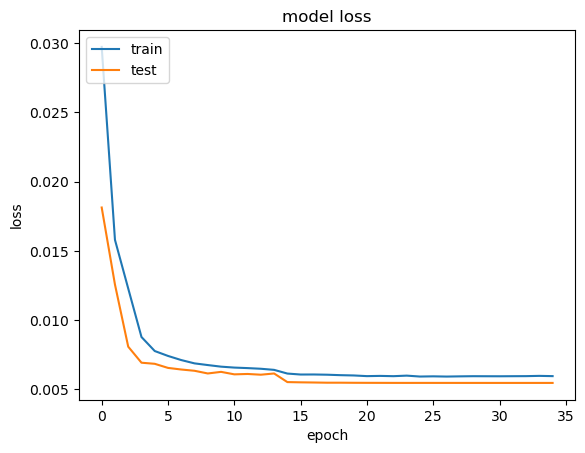

In [15]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(9442, 1)


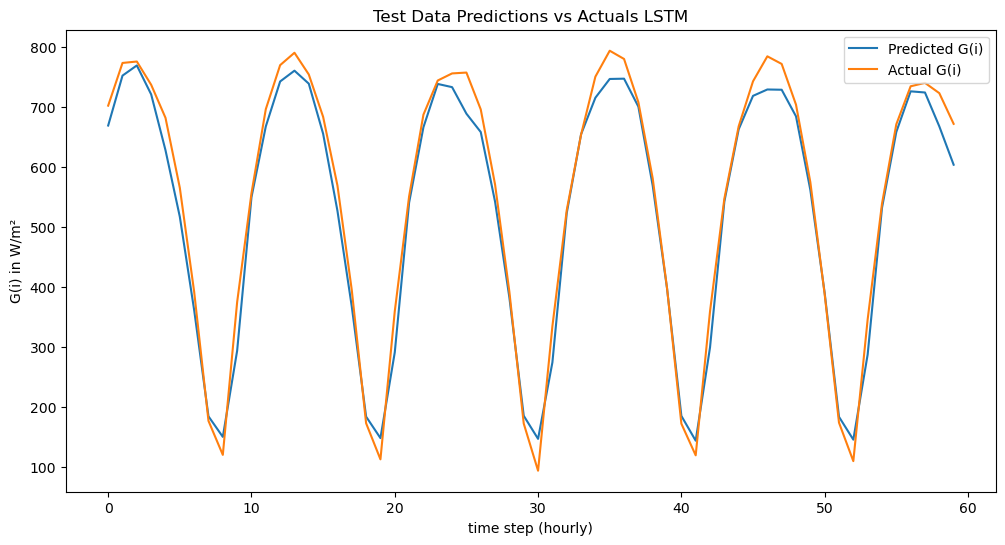

In [29]:
# Access the mean and standard deviation for the first feature
# data_mean = scaler.mean_[0]
# data_std = scaler.scale_[0]

# Predict on the test set and flatten the output
Test_prediction = model_simple_lstm.predict(X_test1)


y_test1 = y_test1.flatten().reshape(-1, 1)
print(y_test1.shape)

# Manually inverse transform the predictions and actuals
Test_Predictions_transformed = scaler.inverse_transform(Test_prediction).flatten()
y_test1_transformed = scaler.inverse_transform(y_test1).flatten()

# Prepare the DataFrame with actual and predicted values
test_results = pd.DataFrame({
    'Test Predictions': Test_Predictions_transformed,
    'Actuals': y_test1_transformed
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(test_results['Actuals'][0:60], label="Actual G(i)")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals LSTM')
plt.legend()
plt.show()



In [32]:
# Define metrics using NumPy
def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.abs(np.mean(y_pred - y_true))

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

# # Actual and predicted values

# Train_prediction_ERR = model_simple_lstm.predict(X_test1).flatten()

# # Manually inverse transform the predictions and actuals
# # Prepare the DataFrame with actual and predicted values
# train_results = pd.DataFrame({
#     'Test Predictions': Train_prediction_ERR,
#     'Actuals': y_test1
# })

y_true = test_results['Test Predictions'].values
y_pred = test_results['Actuals']

# Calculate metrics
mae_value = mae_np(y_true, y_pred)
mba_value = mba_np(y_true, y_pred)
rmse_value = rmse_np(y_true, y_pred)

print("MAE:", mae_value)
print("MBA:", mba_value)
print("RMSE:", rmse_value)



MAE: 59.217054309485405
MBA: 0.2911470688826145
RMSE: 90.77131085298622


# COMPLEX LSTM

In [19]:
# Define model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), 
                   return_sequences=True, input_shape=(5, 2)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32), 
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Third LSTM layer (using Bidirectional)
    model.add(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=128, step=32), 
                                 return_sequences=False)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Fully connected layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))  # Adjust output layer based on your task (e.g., regression or classification)

    # Compile the model with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=MeanSquaredError(),
        metrics=[mae, mba, rmse]
    )

    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='lstm_uni_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
cp1 = ModelCheckpoint('model_P/model_lstm_complex_best.keras', save_best_only=True)

# Perform the hyperparameter search
tuner.search(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, cp1]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# You can print the best hyperparameters as well
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)

# Fit the best model on the full dataset
history_lstm = best_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, cp1]
)


Trial 30 Complete [00h 01m 11s]
val_loss: 0.15233741700649261

Best val_loss So Far: 0.1476178616285324
Total elapsed time: 00h 16m 49s
Best hyperparameters: {'units_1': 96, 'dropout_1': 0.2, 'units_2': 128, 'dropout_2': 0.2, 'units_3': 32, 'dropout_3': 0.30000000000000004, 'dense_units': 64, 'dropout_4': 0.30000000000000004, 'learning_rate': 0.008751423768165307, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1696 - mae: 1.0746 - mba: 0.0728 - rmse: 1.3364 - val_loss: 0.1472 - val_mae: 1.0515 - val_mba: 0.0733 - val_rmse: 1.3124
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1685 - mae: 1.0731 - mba: 0.0653 - rmse: 1.3347 - val_loss: 0.1477 - val_mae: 1.0658 - val_mba: 0.0756 - val_rmse: 1.3331
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1642 - mae: 1.0729 - mba: 0.0660 - rmse: 1.3338 - val_loss: 0.1463 - val_mae: 1.0480 -

In [20]:
test_loss, test_mae, test_mba, test_rmse = best_model.evaluate(X_test1, y_test1)
print(f'Test MAE: {test_mae}, Test MBA: {test_mba}, Test RMAE: {test_rmse}%')

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1440 - mae: 1.0009 - mba: 0.0692 - rmse: 1.2448
Test MAE: 1.0125583410263062, Test MBA: 0.06992461532354355, Test RMAE: 1.260017991065979%


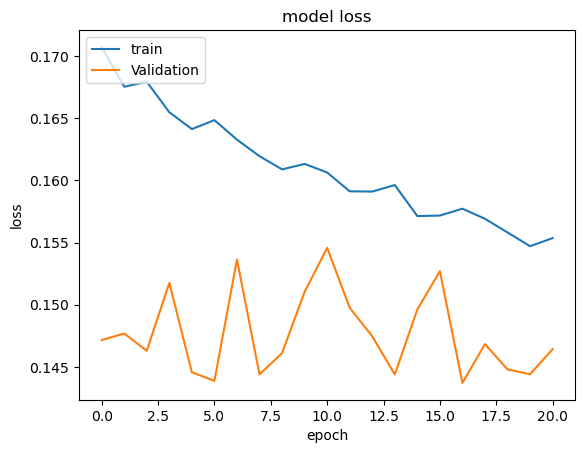

In [21]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0660 - mae: 1.1229 - mba: 0.0567 - rmse: 1.4176
Test MAE: winter, Test MBA: 0.06452860683202744, Test RMAE: 1.423364520072937%
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2412 - mae: 0.8336 - mba: 0.0834 - rmse: 1.0233
Test MAE: summer, Test MBA: 0.08555273711681366, Test RMAE: 1.020506739616394%
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1077 - mae: 1.0547 - mba: 0.0492 - rmse: 1.3177
Test MAE: spring, Test MBA: 0.04981107637286186, Test RMAE: 1.3038372993469238%
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1445 - mae: 1.0777 - mba: 0.0530 - rmse: 1.3363
Test MAE: fall, Test MBA: 0.05270209535956383, Test RMAE: 1.3372801542282104%


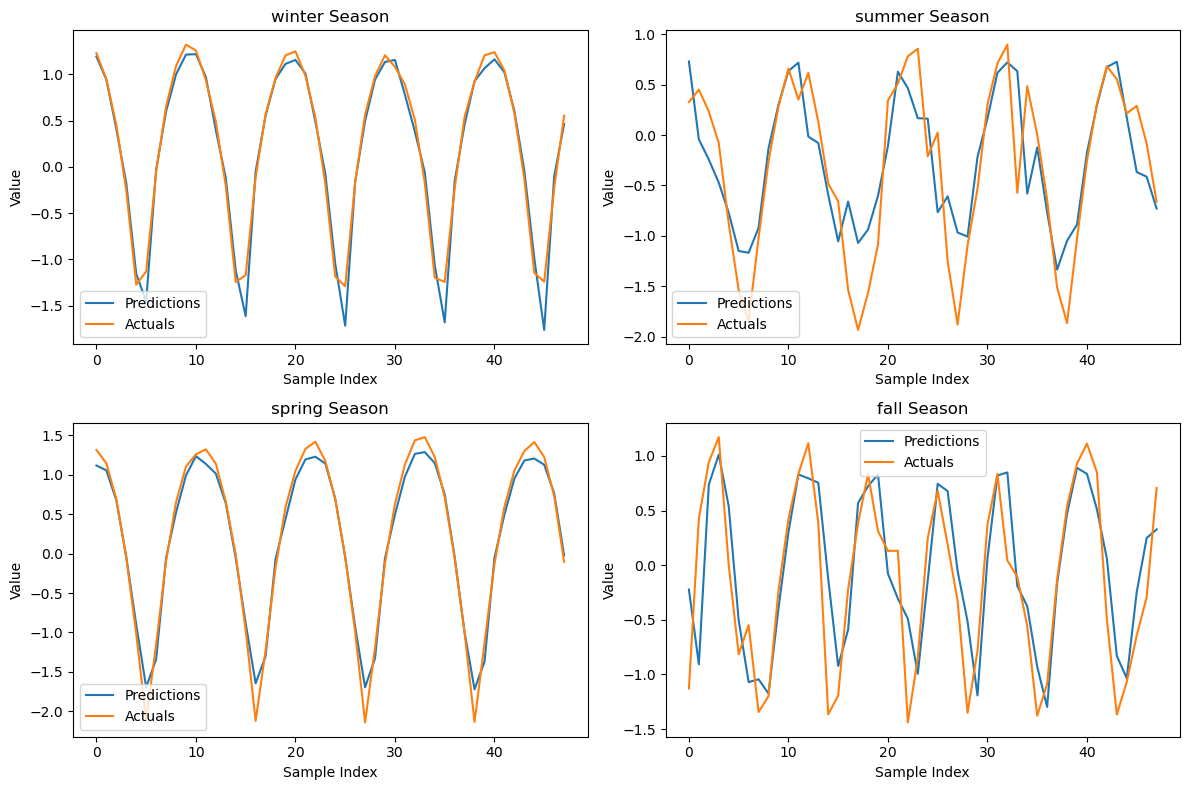

In [22]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_model.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = best_model.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][0:48], label='Predictions')
    ax.plot(train_results['Actuals'][0:48], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()
    

# SIMPLE GRU

In [23]:
def build_optimized_gru_model():
    model = Sequential()
    seq_length=5
    num_features=2
    
    # Input layer
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    
    # First GRU layer
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Second GRU layer
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Third GRU layer
    model.add(GRU(units=64))
    model.add(Dropout(rate=0.1))
    
    # Fully connected layer
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # Output layer
    model.add(Dense(1))  # Linear activation for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Instantiate the model
best_simple_model_gru=build_optimized_gru_model()

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_SIMPLE_GRU_Best.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)



# print(best_model.summary())
history_GRU = best_simple_model_gru.fit(
    X_train1, y_train1,
    epochs=200,
    validation_data=(X_val1,y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    batch_size=64,
    verbose=1,
    shuffle=False
)

Epoch 1/200
667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6159 - mae: 0.6260
Epoch 1: val_loss improved from inf to 0.25902, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6147 - mae: 0.6252 - val_loss: 0.2590 - val_mae: 0.3642 - learning_rate: 1.0000e-04
Epoch 2/200
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2531 - mae: 0.3644
Epoch 2: val_loss improved from 0.25902 to 0.19125, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2531 - mae: 0.3643 - val_loss: 0.1913 - val_mae: 0.3062 - learning_rate: 1.0000e-04
Epoch 3/200
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1985 - mae: 0.3156
Epoch 3: val_loss improved from 0.19125 to 0.17532, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1985 - mae: 0.3156 - val_loss: 0.1753 - val_mae: 0.2812 - learning_rate: 1.0000e-04
Epoch 4/200
668/670 ━━━━━━━━━━━━━

667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1534 - mae: 0.2580
Epoch 23: val_loss improved from 0.15067 to 0.15052, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1534 - mae: 0.2580 - val_loss: 0.1505 - val_mae: 0.2465 - learning_rate: 1.0000e-05
Epoch 24/200
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1516 - mae: 0.2562
Epoch 24: val_loss did not improve from 0.15052
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1516 - mae: 0.2562 - val_loss: 0.1506 - val_mae: 0.2468 - learning_rate: 1.0000e-05
Epoch 25/200
666/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1532 - mae: 0.2583
Epoch 25: val_loss improved from 0.15052 to 0.15046, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1532 - mae: 0.2583 - val_loss: 0.1505 - val_mae: 0.2459 - learning_rate: 1.0000e-05
Epoch 26/200
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1526 - mae: 0.2569
Epoch 26: val_

670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1510 - mae: 0.2552
Epoch 45: val_loss did not improve from 0.14967
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1510 - mae: 0.2552 - val_loss: 0.1498 - val_mae: 0.2455 - learning_rate: 1.0000e-05
Epoch 46/200
667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1514 - mae: 0.2556
Epoch 46: val_loss improved from 0.14967 to 0.14963, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1514 - mae: 0.2556 - val_loss: 0.1496 - val_mae: 0.2452 - learning_rate: 1.0000e-05
Epoch 47/200
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1516 - mae: 0.2554
Epoch 47: val_loss improved from 0.14963 to 0.14960, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1516 - mae: 0.2554 - val_loss: 0.1496 - val_mae: 0.2446 - learning_rate: 1.0000e-05
Epoch 48/200
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1513 - mae: 0.2548
Epoch 48: val_

670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1500 - mae: 0.2538 - val_loss: 0.1489 - val_mae: 0.2431 - learning_rate: 1.0000e-06
Epoch 67/200
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1504 - mae: 0.2542
Epoch 67: val_loss improved from 0.14890 to 0.14890, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1504 - mae: 0.2542 - val_loss: 0.1489 - val_mae: 0.2431 - learning_rate: 1.0000e-06
Epoch 68/200
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1498 - mae: 0.2524
Epoch 68: val_loss did not improve from 0.14890
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1498 - mae: 0.2524 - val_loss: 0.1489 - val_mae: 0.2433 - learning_rate: 1.0000e-06
Epoch 69/200
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1508 - mae: 0.2548
Epoch 69: val_loss did not improve from 0.14890

Epoch 69: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1508 - mae: 0.

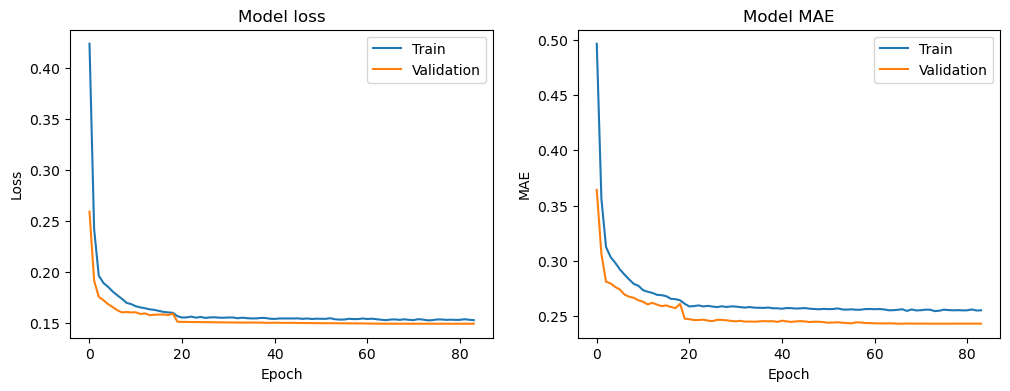

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['mae'])
plt.plot(history_GRU.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


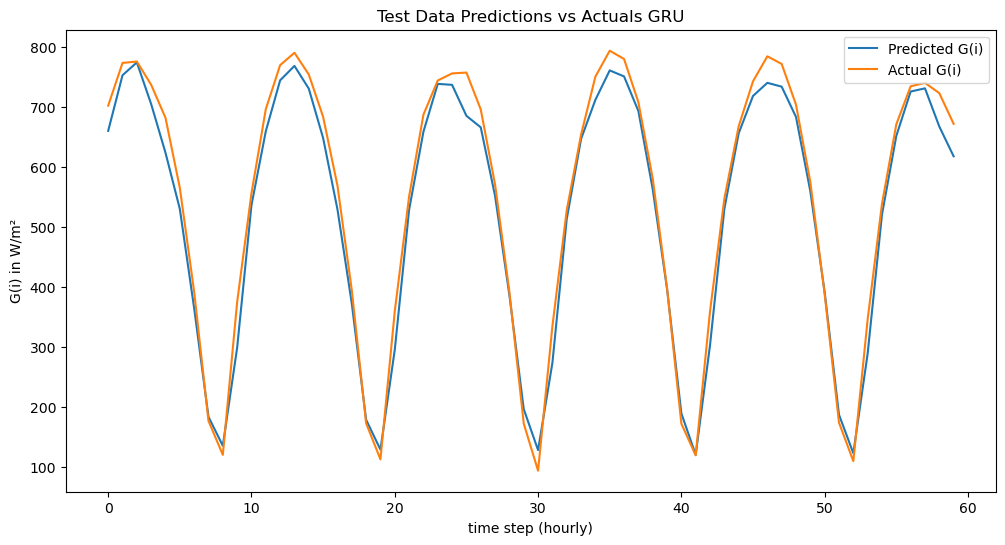

In [91]:
# Access the mean and standard deviation for the first feature
data_mean = scaler.mean_[0]
data_std = scaler.scale_[0]

# Load the best GRU model
best_model_gru = tf.keras.models.load_model('model_optimized_SIMPLE_GRU_Best.keras')

# Predict on the test set and flatten the output
Test_prediction = best_model_gru.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Test_Predictions_transformed = Test_prediction * data_std + data_mean
y_test1_transformed = y_test1 * data_std + data_mean

# Prepare the DataFrame with actual and predicted values
test_results = pd.DataFrame({
    'Test Predictions': Test_Predictions_transformed,
    'Actuals': y_test1_transformed
})

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(test_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(test_results['Actuals'][0:60], label="Actual G(i)")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals GRU')
plt.legend()
plt.show()


In [92]:
# Actual and predicted values

Train_prediction_ERR = best_model_gru.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_prediction_ERR,
    'Actuals': y_test1
})

y_true = train_results['Test Predictions'].values
y_pred = train_results['Actuals']

# Calculate metrics
mae_value = mae_np(y_true, y_pred)
mba_value = mba_np(y_true, y_pred)
rmse_value = rmse_np(y_true, y_pred)

print("MAE:", mae_value)
print("MBA:", mba_value)
print("RMSE:", rmse_value)


296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 0.24804764548195976
MBA: 0.004776598075373473
RMSE: 0.3889734346339181


# COMPLEX GRU

In [26]:
# Define model-building function for Keras Tuner
def build_gru_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(5, 2)))  # Assuming input shape (5, 7) (or whatever shape you have)

    # Add a stack of GRU layers with increasing complexity
    model.add(GRU(units=hp.Int('gru_units_1', min_value=32, max_value=128, step=32), 
                  return_sequences=True))  # First GRU layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(GRU(units=hp.Int('gru_units_2', min_value=32, max_value=128, step=32), 
                  return_sequences=True))  # Second GRU layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(GRU(units=hp.Int('gru_units_3', min_value=32, max_value=128, step=32)))  # Final GRU layer
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    # Dense layers to increase model complexity
    model.add(Dense(units=hp.Int('dense_units_1', min_value=8, max_value=64, step=8), activation='relu'))  # Dense layer
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(Dense(units=hp.Int('dense_units_2', min_value=8, max_value=64, step=8), activation='relu'))  # Dense layer

    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile the model with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=MeanSquaredError(),
        metrics=[mae, mba, rmse]
    )

    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_gru_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_gru_dir',
    project_name='gru_uni_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
cp1 = ModelCheckpoint('model_G(I)/gru_model_best.keras', save_best_only=True)

# Perform the hyperparameter search
tuner.search(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, cp1]
)

# Get the best model
best_model_gru = tuner.get_best_models(num_models=1)[0]

# You can print the best hyperparameters as well
best_hyperparameters_gru = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters_gru.values)

# Fit the best model on the full dataset
history_gru = best_model_gru.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, cp1]
)

Trial 30 Complete [00h 01m 31s]
val_loss: 0.1776331067085266

Best val_loss So Far: 0.15069681406021118
Total elapsed time: 00h 15m 43s
Best hyperparameters: {'gru_units_1': 96, 'dropout_1': 0.30000000000000004, 'gru_units_2': 96, 'dropout_2': 0.30000000000000004, 'gru_units_3': 128, 'dropout_3': 0.4, 'dense_units_1': 16, 'dropout_4': 0.2, 'dense_units_2': 40, 'learning_rate': 0.0023385968908569412, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1630 - mae: 1.0692 - mba: 0.0647 - rmse: 1.3311 - val_loss: 0.1695 - val_mae: 1.0065 - val_mba: 0.0732 - val_rmse: 1.2428
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1612 - mae: 1.0764 - mba: 0.0606 - rmse: 1.3396 - val_loss: 0.1712 - val_mae: 1.0080 - val_mba: 0.0873 - val_rmse: 1.2445
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1563 - mae: 1.0798 - mba: 0.0611 - rmse: 1.3450 - 

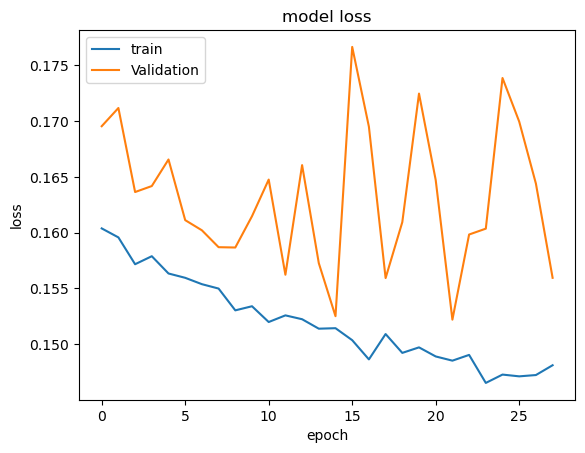

In [27]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

542/542 ━━━━━━━━━━━━━━━━━━━━ 1000s 2ms/step
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0837 - mae: 1.1091 - mba: 0.0827 - rmse: 1.3892
Test MAE: winter, Test MBA: 0.08050866425037384, Test RMAE: 1.3948136568069458%
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2440 - mae: 0.8326 - mba: 0.0815 - rmse: 1.0207
Test MAE: summer, Test MBA: 0.08118162304162979, Test RMAE: 1.016944169998169%
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1235 - mae: 1.0409 - mba: 0.0803 - rmse: 1.2903
Test MAE: spring, Test MBA: 0.07708892226219177, Test RMAE: 1.2789998054504395%
505/505 ━━━━━━━━━━━━━━━━━━━━ 382s 1ms/step
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1593 - mae: 1.0656 - mba: 0.0848 - rmse: 1.3160
Test MAE: fall, Test MBA: 0.08011449873447418, Test RMAE: 1.3155245780944824%


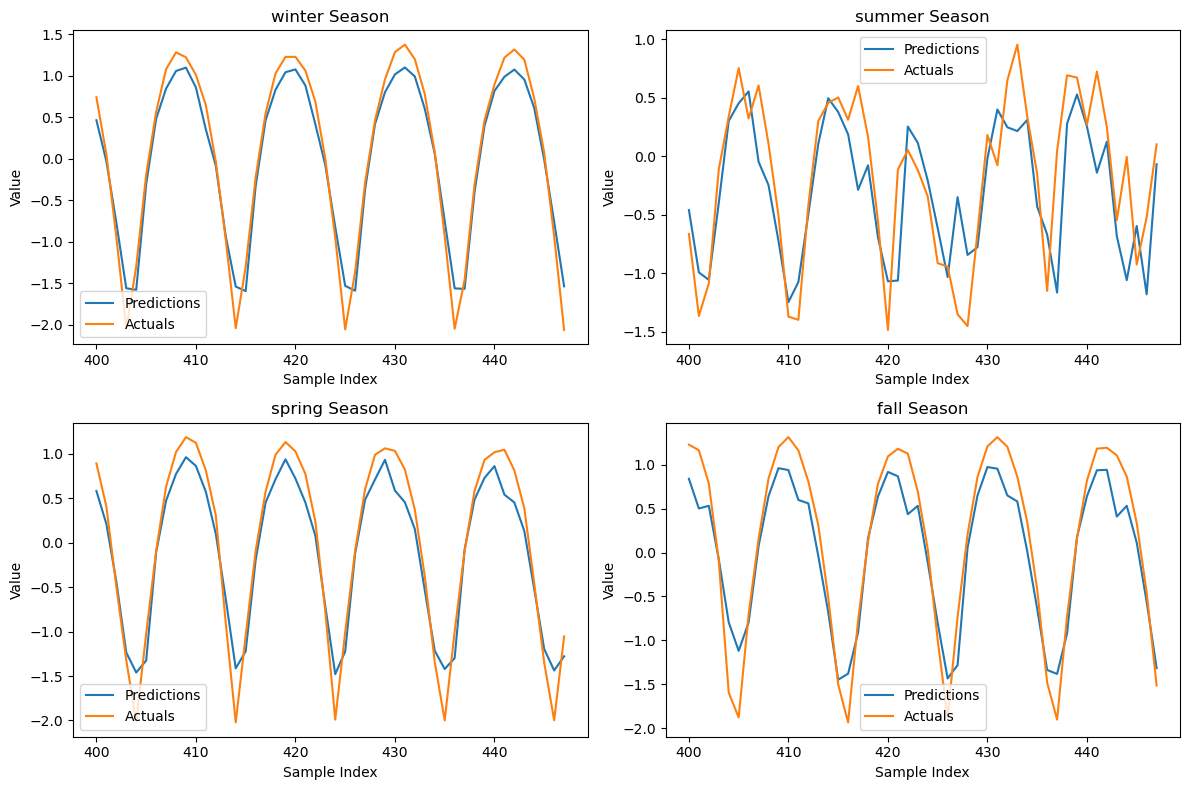

In [28]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_model_gru.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = best_model_gru.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][400:448], label='Predictions')
    ax.plot(train_results['Actuals'][400:448], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()

# Hybrid

In [30]:
from keras.layers import Input, LSTM, Dense, Conv1D, ReLU, Add, Layer, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

# Custom Residual Block with projection to match input and output shapes
class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu1 = ReLU()
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu2 = ReLU()
        self.add = Add()
        
        # Projection layer to match input and output shapes if needed
        self.projection = Conv1D(filters=filters, kernel_size=1, padding='same') if filters != 64 else None
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.conv2(x)
        
        # Project input if necessary to match the shape
        if self.projection is not None:
            inputs = self.projection(inputs)
        
        x = self.add([inputs, x])  # Residual connection
        x = self.relu2(x)
        return x

# Define the model-building function for Keras Tuner
def build_model(hp):
    # Input shape for your data
    input_shape = (5, 2)  # Update this as per your data
    inputs = Input(shape=input_shape)
    
    # LSTM Layers
    x = LSTM(256, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=False)(x)  # Output a single vector

    # Reshape to add an extra time dimension for Conv1D compatibility
    x = Reshape((1, 64))(x)  # Shape now is (batch_size, 1, 64)
    
    # Residual Blocks with increasing dilation rates (dilation_rate is tunable)
    for dilation_rate in [1, 2, 4]:
        x = ResidualBlock(
            filters=hp.Int('conv_filters', min_value=64, max_value=128, step=32),
            kernel_size=hp.Int('kernel_size', min_value=3, max_value=5, step=1),
            dilation_rate=dilation_rate
        )(x)
    
    # Flatten the output before passing to the final Dense layer
    x = Reshape((-1,))(x)  # Flatten to (batch_size, features)
    
    # Fully Connected (Dense) Layer with a single output
    x = Dense(units=1, activation='linear')(x)  # Single output value
    
    # Model creation
    model = Model(inputs=inputs, outputs=x)
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mse',  # Mean Squared Error for regression
        metrics=['mae']  # Only using MAE for simplicity
    )
    return model

# Set up the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='hybrid_tuner_uni_project'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_G(I)/hybrid_model_best.keras', save_best_only=True)

# Start the search for the best model
tuner.search(X_train1, y_train1, epochs=50, validation_data=(X_val1, y_val1), callbacks=[early_stopping, model_checkpoint])

# Retrieve the best model
best_hybrid_model = tuner.get_best_models(num_models=1)[0]

# Model summary of the best model
best_hybrid_model.summary()

# Print the best hyperparameters
best_hyperparameters_hybrid = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters_hybrid.values)

# Fit the best model on the full dataset
history_hybrid = best_hybrid_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)


Trial 18 Complete [00h 00m 45s]
val_loss: 0.16938696801662445

Best val_loss So Far: 0.15283089876174927
Total elapsed time: 09h 19m 02s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 256)         │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 1, 96)          │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 1, 96)          │       101,664 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 1, 96)          │       101,664 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 798,401 (3.05 MB)

 Trainable params: 798,401 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters: {'conv_filters': 96, 'kernel_size': 5, 'optimizer': 'adam', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1550 - mae: 0.2564 - val_loss: 0.1476 - val_mae: 0.2374
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.1488 - mae: 0.2453 - val_loss: 0.1503 - val_mae: 0.2517
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1441 - mae: 0.2402 - val_loss: 0.1539 - val_mae: 0.2413
Epoch 4/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1434 - mae: 0.2402 - val_loss: 0.1513 - val_mae: 0.2435
Epoch 5/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.1424 - mae: 0.2368 - val_loss: 0.1534 - val_mae: 0.2399
Epoch 6/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1389 - mae: 0.2311 - val_loss: 0.1555 - val_mae: 0.2590
Epoch 7/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.1409 - mae: 0.2350 - val_loss: 0.1429

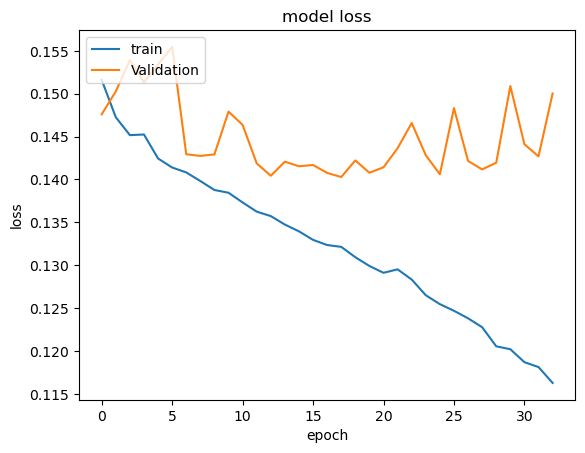

In [31]:
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

542/542 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


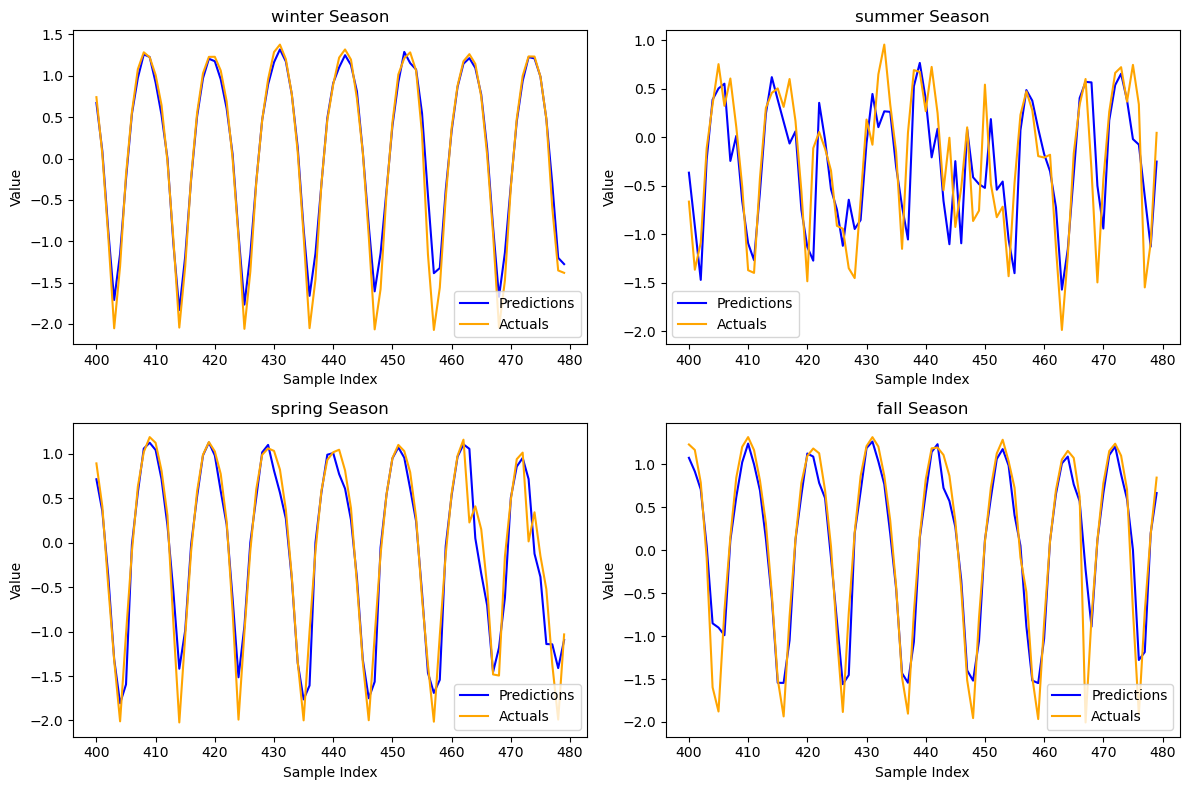

In [32]:
season_list_x = [X_winter, X_summer, X_spring, X_fall] 
season_list_y = [y_winter, y_summer, y_spring, y_fall] 
season_names = ["winter", "summer", "spring", "fall"]

# Create a 2x2 plot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each season and plot predictions vs actual values
for idx, (X_season, y_season) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_hybrid_model.predict(X_season)
    
    # Flatten the predictions and actual values (if needed)
    train_predictions = train_predictions.flatten()
    y_season = y_season.flatten()

    # Create a DataFrame for easier comparison
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_season})

    # Plot the first 250 samples for better visualization
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][400:480], label='Predictions', color='blue')
    ax.plot(train_results['Actuals'][400:480], label='Actuals', color='orange')

    # Set title, labels, and legend
    ax.set_title(f"{season_names[idx]} Season")
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend()

# Improve layout for clarity
plt.tight_layout()
plt.show()

# Real Time Data

In [20]:
real_data_df = pd.read_excel('Real_PV_data.xlsx' )
real_data_df.head(10)

,Date,Time,Areza - PV Generation Meter - Specific Energy (kWh/kWp)
0,01/01/2023,01:00,-0.25
1,01/01/2023,02:00,0.00
2,01/01/2023,03:00,-0.25
3,01/01/2023,04:00,0.00
4,01/01/2023,05:00,0.00
5,01/01/2023,06:00,-0.25
6,01/01/2023,07:00,2.25
7,01/01/2023,08:00,149.50
8,01/01/2023,09:00,437.25
9,01/01/2023,10:00,388.75


In [21]:
real_data_df= real_data_df[real_data_df['Areza - PV Generation Meter - Specific Energy (kWh/kWp)'] > 10]
# Combine Date and Time into a single datetime column
real_data_df["Datetime"] = pd.to_datetime(
    real_data_df["Date"] + " " + real_data_df["Time"],
    format="%d/%m/%Y %H:%M"
)

# Set Datetime as the index
real_data_df.set_index("Datetime", inplace=True)
real_data_df.drop(columns=["Date", "Time"], inplace=True)
real_data_df['P'] = real_data_df['Areza - PV Generation Meter - Specific Energy (kWh/kWp)']
# real_data_df['Season'] = real_data_df.index.month.map(get_season)
real_data_df.drop(['Areza - PV Generation Meter - Specific Energy (kWh/kWp)'],axis=1, inplace = True)
 
real_data_df.head(20)

,P
Datetime,
2023-01-01 08:00:00,149.50
2023-01-01 09:00:00,437.25
2023-01-01 10:00:00,388.75
2023-01-01 11:00:00,433.25
2023-01-01 12:00:00,428.00
2023-01-01 13:00:00,435.75
2023-01-01 14:00:00,361.25
2023-01-01 15:00:00,396.50
2023-01-01 16:00:00,199.75


In [22]:
scaled_real_data_df = scaler.transform(real_data_df)
X1, y1 = df_to_X_y(scaled_real_data_df, WINDOW_SIZE)
y1.shape

(4387,)

In [23]:
models = {
    "model_simple_lstm": model_simple_lstm,
#     "best_model": best_model,
#     "best_simple_model_gru": best_simple_model_gru,
#     "best_model_gru": best_model_gru,
#     "best_hybrid_model": best_hybrid_model,
    }



In [25]:


# Dictionary to store performance metrics
performance = {}

# Access the mean and standard deviation for the first feature
# data_mean = scaler.mean_[0]
# data_std = scaler.scale_[0]

# Iterate over each model
for model_name, model in models.items():
    # Generate predictions
    y_pred_scaled = model.predict(X1).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true_inv = scaler.inverse_transform(y1)
    
    # Calculate performance metrics
    mse = mae_np(y_true_inv, y_pred)
    rmse = rmse_np(y_true_inv,y_pred)
    mbe = mba_np(y_true_inv, y_pred)
    
    # Store the results
    performance[model_name] = {
        "MSE": mse,
        "RMSE": rmse,
        "MBE": mbe,
    }

# Print performance results
for model_name, metrics in performance.items():
    print(f"Performance for {model_name}:")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MBE: {metrics['MBE']:.4f}")
    print()

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
model_simple_lstm
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: Expected 2D array, got 1D array instead:
array=[-0.27336776 -0.5845846  -0.91499877 ... -0.7774196  -1.1873239
 -1.1916418 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [52]:

# # Constants
# day = 60 * 60 * 24  # Seconds in a day
# year = 365.2425 * day  # Average seconds in a year

# # Add a Seconds column based on timestamp
# real_data_df["Seconds"] = real_data_df.index.map(pd.Timestamp.timestamp)

# # Add sine and cosine features
# real_data_df["day_sin"] = np.sin(real_data_df["Seconds"] * (2 * np.pi / day))
# real_data_df["day_cos"] = np.cos(real_data_df["Seconds"] * (2 * np.pi / day))
# real_data_df["year_sin"] = np.sin(real_data_df["Seconds"] * (2 * np.pi / year))
# real_data_df["year_cos"] = np.cos(real_data_df["Seconds"] * (2 * np.pi / year))

# real_data_df.head(20)

,Areza - PV Generation Meter - Specific Energy (kWh/kWp),Seconds,day_sin,day_cos,year_sin,year_cos
Datetime,,,,,,
2023-01-01 08:00:00,149.50,1.672560e+09,8.660254e-01,-5.000000e-01,0.008272,0.999966
2023-01-01 09:00:00,437.25,1.672564e+09,7.071068e-01,-7.071068e-01,0.008988,0.999960
2023-01-01 10:00:00,388.75,1.672567e+09,5.000000e-01,-8.660254e-01,0.009705,0.999953
2023-01-01 11:00:00,433.25,1.672571e+09,2.588190e-01,-9.659258e-01,0.010422,0.999946
2023-01-01 12:00:00,428.00,1.672574e+09,1.867320e-12,-1.000000e+00,0.011139,0.999938
2023-01-01 13:00:00,435.75,1.672578e+09,-2.588190e-01,-9.659258e-01,0.011855,0.999930
2023-01-01 14:00:00,361.25,1.672582e+09,-5.000000e-01,-8.660254e-01,0.012572,0.999921
2023-01-01 15:00:00,396.50,1.672585e+09,-7.071068e-01,-7.071068e-01,0.013289,0.999912
2023-01-01 16:00:00,199.75,1.672589e+09,-8.660254e-01,-5.000000e-01,0.014005,0.999902
